In [1572]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Boilerplate Code

In [2217]:
# Pretty plots
import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})

def setup_plot():
    fig = plt.figure(dpi=200, figsize=(10.0,6.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 30)
    ax.tick_params(direction='in')

In [1574]:
import torch
import gym
from stable_baselines3 import PPO, SAC
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from typing import Callable, Union, Type, Optional, Dict, Any, List
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [1575]:
def create_mlp(
    input_dim: int, output_dim: int, net_arch: List[int], squash=False, activation_fn: Type[nn.Module] = nn.ReLU) -> List[nn.Module]:

    if len(net_arch) > 0:
        modules = [nn.Linear(input_dim, net_arch[0]), activation_fn()]
    else:
        modules = []

    for idx in range(len(net_arch) - 1):
        modules.append(nn.Linear(net_arch[idx], net_arch[idx + 1]))
        modules.append(activation_fn())

    if output_dim > 0:
        last_layer_dim = net_arch[-1] if len(net_arch) > 0 else input_dim
        modules.append(nn.Linear(last_layer_dim, output_dim))
    if squash:
        modules.append(nn.Tanh())
    return modules

In [1576]:
def create_network(i=4, o=2, squash=False):
    net = nn.Sequential(*create_mlp(i, o, [64, 64], squash=squash))
    return net
def policy_wrapper(net):
    pi = lambda s: np.argmax(net(torch.from_numpy(np.array(s)).float()).detach())
    return pi

## Experiment 1: Lunar Lander w/ Truncated State

In [1578]:
env = gym.make("LunarLander-v2")
expert = PPO.load("./experts/LunarLander-v2/lunarlander_expert")

In [1580]:
Js = []
for _ in range(100):
    obs = env.reset()
    J = 0
    done = False
    hs = []
    while not done:
        action, _ = expert.predict(obs)
        obs, reward, done, info = env.step(action)
        hs.append(obs[1])
        J += reward
    Js.append(J)
ll_expert_performance = np.mean(Js)
print('J(pi_E) =', ll_expert_performance)

J(pi_E) = 282.23657317090544


In [1581]:
def gym_rollout(net, env, truncate=True):
    X = []
    U = []
    x = env.reset()
    done = False
    r_tot = 0
    while not done:
        X.append(x.reshape(-1))
        if truncate:
            u = net(torch.from_numpy(np.array(x[:-2])).float())
        else:
            u = net(torch.from_numpy(np.array(x)).float())
        if isinstance(u, torch.FloatTensor) or isinstance(u, torch.Tensor):
            u = u.detach().numpy()
        U.append(u.reshape(-1))
        x, r, done, _ = env.step(np.argmax(u))
        r_tot += r
    X = np.array(X, dtype='float')
    U = np.array(U, dtype='float')
    return X, U

In [1582]:
def eval_policy(pi, env, truncate=True):
    done = False
    x = env.reset()
    r_tot = 0
    while not done:
        if truncate:
            u = pi(x[:-2])
        else:
            u = pi(x)
        if isinstance(u, torch.FloatTensor) or isinstance(u, torch.Tensor):
            u = u.detach().numpy()
        x, r, done, _ = env.step(u)
        r_tot += r
    return r_tot

In [1583]:
def BC(X, U, net, loss_fn=nn.CrossEntropyLoss()):
    optimizer = optim.Adam(net.parameters(), lr=3e-4)
    for step in range(int(1e4)):
        idx = np.random.choice(len(X), 32)
        states = torch.from_numpy(X[idx])
        actions = torch.from_numpy(U[idx])

        optimizer.zero_grad()

        outputs = net(states.float())
        loss = loss_fn(outputs, actions.reshape(-1))
        loss.backward()
        optimizer.step()
    return policy_wrapper(net)

In [1584]:
def expert_wrapper(expert, s):
    action = expert.predict(s)[0]
    padded = np.zeros(4)
    padded[action] = 1
    return padded

### Algorithm 1: DAgger

In [1586]:
def DAgger(env, truncate=True):
    if truncate:
        net = create_network(i=6, o=4)
    else:
        net = create_network(i=8, o=4)
    policy = policy_wrapper(net)
    
    X = []
    U = []
    J = []
    
    for i in range(10):
        J.append(np.mean([eval_policy(policy, env, truncate=truncate) for _ in range(10)]))
        print(i, 'DAgger', J[-1])
        
        if i > 0:
            rollouts = [gym_rollout(net, env, truncate=truncate) for _ in range(10)]
        else:
            rollouts = [gym_rollout(lambda s: expert_wrapper(expert, s), env, truncate=False) for _ in range(10)]
            
        X_new = np.concatenate([r[0] for r in rollouts], axis=0)
        U_new = expert.predict(X_new)[0].reshape(len(X_new), -1)
        
        X.extend(X_new.tolist())
        U.extend(U_new.tolist())
        
        if truncate:
            BC(np.array(X)[:, :-2], np.array(U), net)
        else:
            BC(np.array(X), np.array(U), net)
            
    return J

In [1587]:
num_trials = 5
dagger_scores = []
for trial in range(num_trials):
    dagger_scores.append(DAgger(env))
dagger_scores = np.array(dagger_scores)

0 DAgger -610.7617293334588
1 DAgger 213.42213316982165
2 DAgger 283.31688566653804
3 DAgger 279.0804119827145
4 DAgger 286.57864679175844
5 DAgger 288.99554597888266
6 DAgger 276.3221257969926
7 DAgger 284.95589256986494
8 DAgger 290.1594004008574
9 DAgger 283.04385883739087
0 DAgger -849.0022734805365
1 DAgger 278.2021542434667
2 DAgger 277.4539292077979
3 DAgger 287.5188911812973
4 DAgger 279.3901350473447
5 DAgger 274.3364388934557
6 DAgger 290.3086779476418
7 DAgger 279.3144177721034
8 DAgger 282.7605586123142
9 DAgger 286.17942276152513
0 DAgger -315.8799473862658
1 DAgger 59.770738407449905
2 DAgger 272.1134592779832
3 DAgger 268.58671877360723
4 DAgger 290.94018509321796
5 DAgger 269.69198121525363
6 DAgger 278.4728003352173
7 DAgger 280.97424632413026
8 DAgger 277.21360099354126
9 DAgger 281.36705241024185
0 DAgger -476.3501831155515
1 DAgger 173.13112679943248
2 DAgger 280.88161329568885
3 DAgger 272.22954447391567
4 DAgger 283.98877992875583
5 DAgger 279.35293506464336
6 DAg

In [1588]:
print('DAgger', dagger_scores.mean(axis=0))

DAgger [-536.73121408  191.54474625  277.92522166  272.88622012  284.43230501
  278.31396544  282.1899883   281.53585413  282.71986676  280.95132669]


### Algorithm 2: DAeQuIL

In [20]:
def gradient_penalty(learner_sa, expert_sa, f, target=0.0, w=1.0):
    batch_size = expert_sa.size()[0]

    alpha = torch.ones(batch_size, 1) * w
    alpha = alpha.expand_as(expert_sa)

    interpolated = alpha * expert_sa.data + (1 - alpha) * learner_sa.data
    interpolated = Variable(interpolated, requires_grad=True)

    f_interpolated = f(interpolated.float())

    gradients = torch_grad(outputs=f_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(f_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    norm = gradients.norm(2, dim=1).mean().item()
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    return ((gradients_norm - target) ** 2).mean()

In [1614]:
def disc_update(X, U_pi, U_expert, X_agg, U_pi_agg, U_expert_agg, truncate=True):
    f = create_network(i=8+4, o=1, squash=False)
    optimizer = optim.Adam(f.parameters(), lr=3e-4)
    
    states_agg = torch.from_numpy(X_agg)
    a_pi_agg = torch.from_numpy(U_pi_agg)
    a_E_agg = torch.squeeze(nn.functional.one_hot(torch.from_numpy(U_expert_agg), 4))
    learner_sa_agg = torch.cat((states_agg, a_pi_agg), axis=1)
    expert_sa_agg = torch.cat((states_agg, a_E_agg), axis=1)
    
    for step in range(int(1e3)): # This number needs to be tuned per-problem.
        idx = np.random.choice(len(X), 32)

        states = torch.from_numpy(X[idx])
        a_pi = torch.from_numpy(U_pi[idx])
        a_E = torch.squeeze(nn.functional.one_hot(torch.from_numpy(U_expert[idx]), 4))

        learner_sa = torch.cat((states, a_pi), axis=1)
        expert_sa = torch.cat((states, a_E), axis=1)
        

        f_learner = f(learner_sa.float())
        f_expert = f(expert_sa.float())
        gp = gradient_penalty(learner_sa, expert_sa, f, w=1.0) + gradient_penalty(learner_sa, expert_sa, f, w=0.0)
        
        optimizer.zero_grad()
        loss = f_expert.mean() - f_learner.mean() + 5 * gp 
        
        loss.backward()
        optimizer.step()
    return f

In [1650]:
def gen_update(X, F, U, net, pi_opt, num_bc=0, first_iter=False, truncate=True):
    loss_fn = nn.CrossEntropyLoss()
    
    for step in range(int(3e3)):
        # BC component
        bc_states = torch.from_numpy(X[:num_bc])
        bc_actions = torch.from_numpy(U[:num_bc])
        if not first_iter:
            idx = np.random.choice(len(X) - num_bc, 32)
            states = torch.from_numpy(X[idx + num_bc])
            expert_actions = torch.squeeze(nn.functional.one_hot(torch.from_numpy(U[idx + num_bc]), 4))
            discs = [F[i] for i in idx + num_bc]

        bc_idx = np.random.choice(num_bc, 32)
        pi_opt.zero_grad()
        if truncate:
            bc_preds = net(bc_states[bc_idx].float()[:, :-2])
        else:
            bc_preds = net(bc_states[bc_idx].float())
        bc_loss = loss_fn(bc_preds, bc_actions[bc_idx].reshape(-1))
        
        # Moment Matching component
        mm_loss = 0.       
        if not first_iter:
            if truncate:
                outputs = net(states.float()[:, :-2])
                probs = torch.softmax(outputs, dim=-1)
                learner_sa = torch.cat((states, probs), axis=1)
            else:
                outputs = net(states.float())
                probs = torch.softmax(outputs, dim=-1)
                learner_sa = torch.cat((states, probs), axis=1)
            mm_loss += torch.mean(torch.stack([discs[i](learner_sa[i:i+1].float()) for i in range(len(idx))]))
            
        loss = mm_loss * (1 - (num_bc / len(X))) + 1 * bc_loss * (num_bc / len(X))
        loss.backward()
        pi_opt.step()
       
    return policy_wrapper(net)

In [1651]:
def DAeQuIL(env, truncate=True):
    if truncate:
        net = create_network(i=6, o=4)
    else:
        net = create_network(i=8, o=4)
    policy = policy_wrapper(net)
    pi_opt = optim.Adam(net.parameters(), lr=3e-4)
    
    X = []
    U = []
    J = []
    U_learner = []
    F = []
    
    for i in range(10):
        J.append(np.mean([eval_policy(policy, env, truncate=truncate) for _ in range(10)]))
        print(i, 'DAeQuIL', J[-1])
        
        if i > 0:
            rollouts = [gym_rollout(net, env, truncate=truncate) for _ in range(10)]
        else:
            rollouts = [gym_rollout(lambda s: expert_wrapper(expert, s), env, truncate=False) for _ in range(10)]
            
        X_new = np.concatenate([r[0] for r in rollouts], axis=0)
        U_pi = np.concatenate([r[1] for r in rollouts], axis=0)
        U_new = expert.predict(X_new)[0].reshape(len(X_new), -1)
        
        X.extend(X_new.tolist())
        U.extend(U_new.tolist())
        U_learner.extend(U_pi.tolist())
        
        # f update (best-response)
        f_t = disc_update(np.array(X_new), np.array(U_pi), np.array(U_new),
                          np.array(X), np.array(U_learner), np.array(U),
                         truncate=truncate)
        F.extend([f_t for _ in range(len(X_new))])
        
        # pi update (no-regret)
        if i == 0:
            num_bc = len(X_new)
            gen_update(np.array(X), F, np.array(U), net, pi_opt, num_bc, first_iter=True, truncate=truncate)
        else:
            gen_update(np.array(X), F, np.array(U), net, pi_opt, num_bc, truncate=truncate)
            
    return J

In [1654]:
num_trials = 5

In [1655]:
daequil_scores = []
for trial in range(num_trials):
    daequil_scores.append(DAeQuIL(env))
daequil_scores = np.array(daequil_scores)

0 DAeQuIL -132.61618305296378
1 DAeQuIL 177.0228764072221
2 DAeQuIL 254.84311782667265
3 DAeQuIL 275.1949507357677
4 DAeQuIL 291.92952436847656
5 DAeQuIL 284.2852744422306
6 DAeQuIL 285.1613810692299
7 DAeQuIL 284.99632609312323
8 DAeQuIL 292.04919968660005
9 DAeQuIL 274.07246666715025
0 DAeQuIL -817.4519274974723
1 DAeQuIL -99.98407724225046
2 DAeQuIL 239.69870803202548
3 DAeQuIL 239.0816067101096
4 DAeQuIL 271.32255989139946
5 DAeQuIL 267.6570229328532
6 DAeQuIL 275.5295661784261
7 DAeQuIL 253.88851815002803
8 DAeQuIL 161.6659943764642
9 DAeQuIL 220.84675312272276
0 DAeQuIL -609.3693058540921
1 DAeQuIL 197.3545494672049
2 DAeQuIL 193.33301980161448
3 DAeQuIL 272.52919709289176
4 DAeQuIL 274.93270286051995
5 DAeQuIL 277.36052894196007
6 DAeQuIL 294.1185089708439
7 DAeQuIL 284.38725350502386
8 DAeQuIL 280.4040159459874
9 DAeQuIL 209.39234182148806
0 DAeQuIL -578.022908393141
1 DAeQuIL -5.996101988965177
2 DAeQuIL 241.80783913079412
3 DAeQuIL 252.78236350874099
4 DAeQuIL 273.40475953580

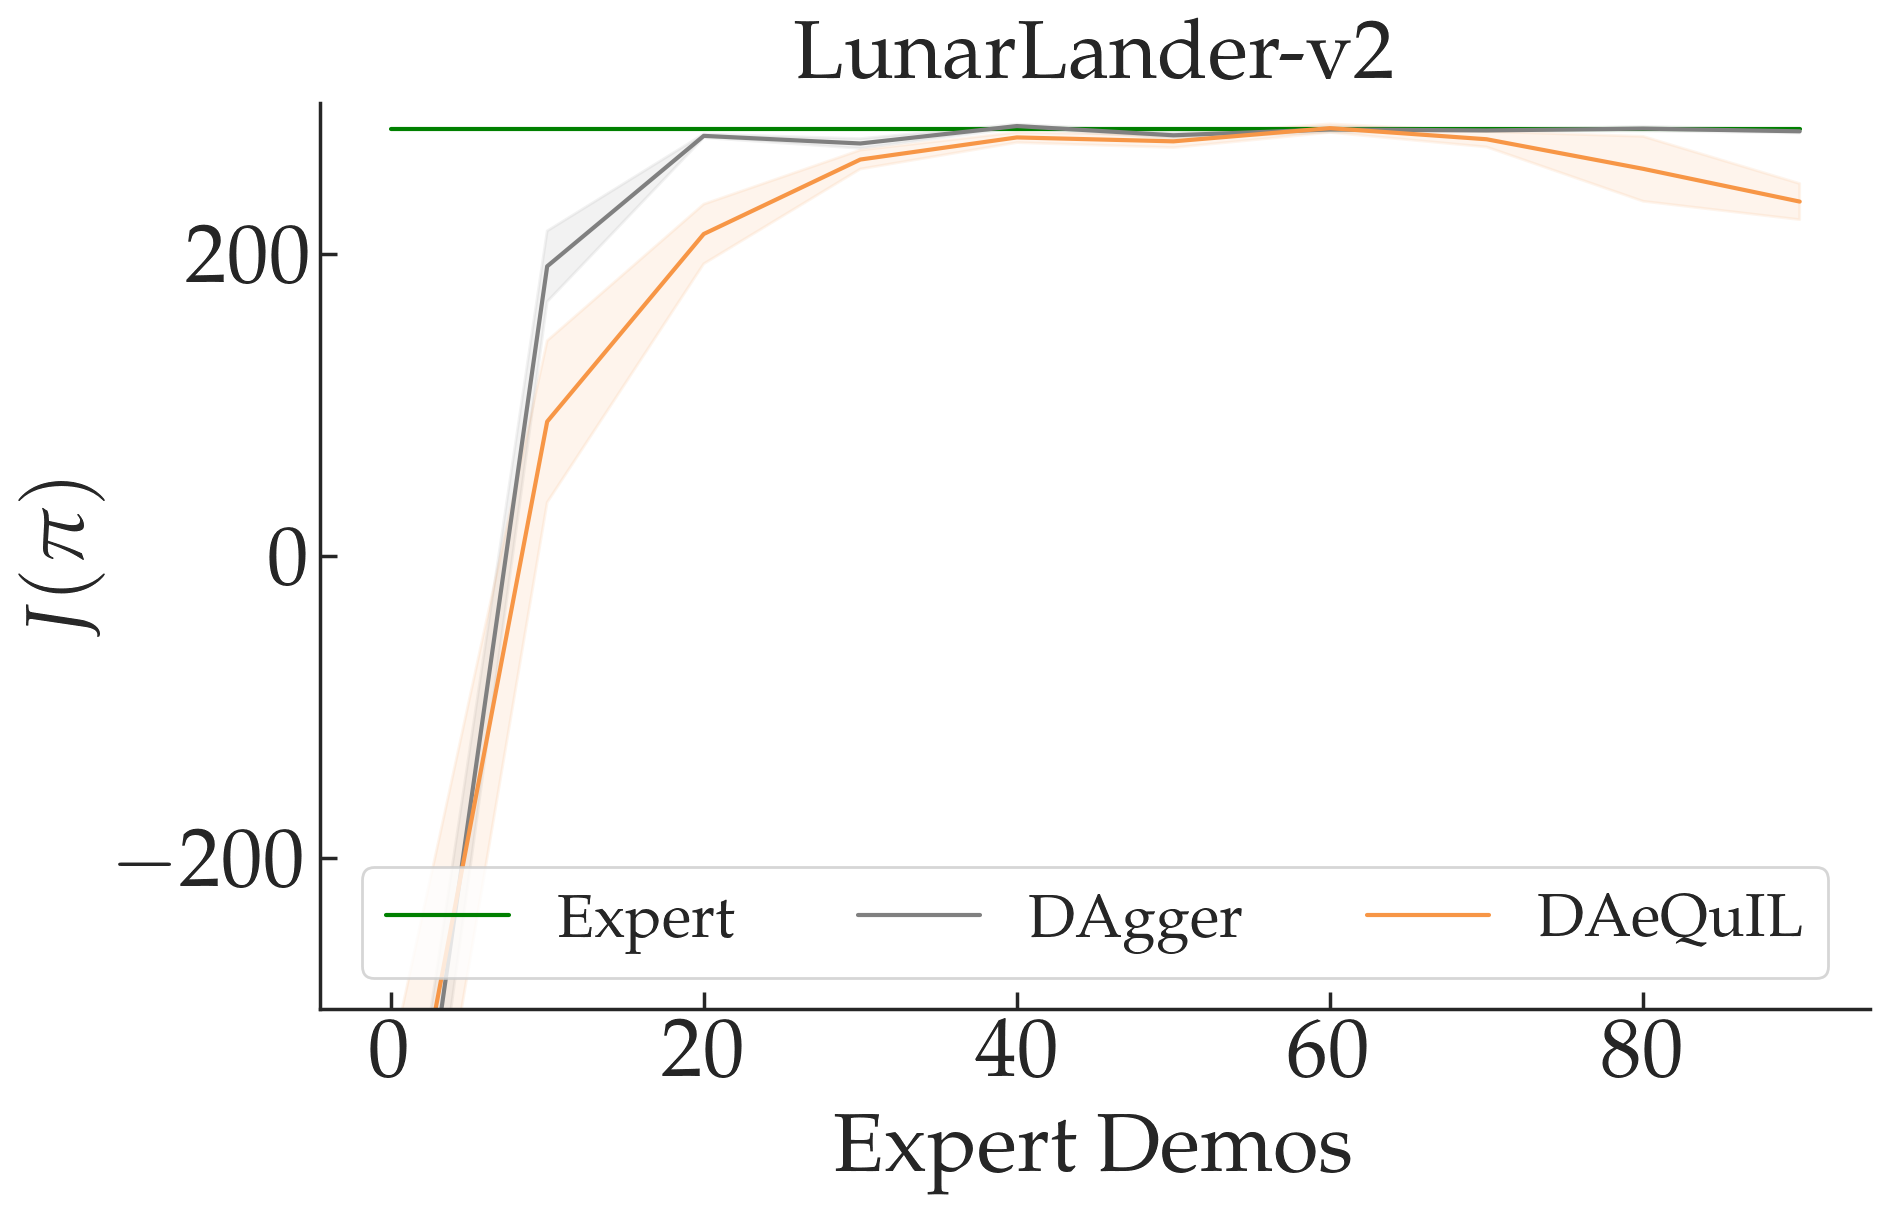

In [2222]:
setup_plot()
x_val = np.arange(10) * 10
plt.plot(x_val, [ll_expert_performance for _ in x_val], label="Expert", color="#008000")
plt.plot(x_val, dagger_scores.mean(axis=0), label="DAgger", color="gray")
plt.fill_between(x_val,
                 dagger_scores.mean(axis=0) - dagger_scores.std(axis=0) / np.sqrt(num_trials),
                 dagger_scores.mean(axis=0) + dagger_scores.std(axis=0) / np.sqrt(num_trials),
                color="gray",
                alpha=0.1)
plt.plot(x_val, daequil_scores.mean(axis=0), label="DAeQuIL", color="#F79646")
plt.fill_between(x_val,
                 daequil_scores.mean(axis=0) - daequil_scores.std(axis=0) / np.sqrt(5),
                 daequil_scores.mean(axis=0) + daequil_scores.std(axis=0) / np.sqrt(5),
                color="#F79646",
                alpha=0.1)
plt.xlabel("Expert Demos", fontsize=30)
plt.ylabel("$J(\pi)$", fontsize=30)
plt.legend(ncol=3, loc="lower center", fontsize=22)
plt.title("LunarLander-v2", fontsize=30)
plt.ylim([-300, 300])
plt.savefig("LunarLander-v2" +"_iact" + ".pdf", dpi=1000, bbox_inches='tight')
plt.show()

For this task, we see DAgger and DAeQuIL perform around the same as matching the mean expert action is all that is required for succesful task completion.

## Experiment 2: Forest Navigation 

Consider an operator trying to teach a drone to fly through a cluttered forest filled with trees. The operator has already trained a perception system that provides state information to the drone about whether a tree is infront of it. Because the operator is primarily concerned with safety, she only cares about making it through the forest, not where on the other side the drone ends up. She also tries to demonstrate a wide variety of evasive maneuvers as to hopefully enable the drone to generalize. Below, we plot the forest she is trying to fly through.

In [2045]:
tree_locs = np.array([[10 * int(idx / 10) + 5 * np.random.uniform(), 5 + 10 * (idx % 10) + 5 * np.random.uniform()] for idx in range(100)])
tree_sizes = np.array([2 + np.random.uniform() for _ in range(100)])

In [2223]:
# np.savez('forest.npz', tree_locs=tree_locs, tree_sizes=tree_sizes)

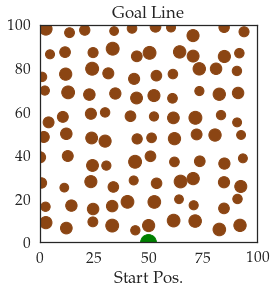

In [2046]:
for i in range(100):
    circle = plt.Circle(tree_locs[i], tree_sizes[i], color='#8B4513')
    plt.gca().add_patch(circle)
plt.scatter(50, 0, color="#008000", s=250)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Start Pos.")
plt.title("Goal Line")
plt.gca().set_aspect("equal")
plt.savefig("forest_env" + ".pdf", dpi=1000, bbox_inches='tight')

The drone has a fixed speed of 5 m/s and the controller simply chooses the angle. The drone starts at (0, 50) and pointing straight forward and can finish anywhere on the other side. Below, we plot some sample optimal trajectories.

In [2047]:
def dynamics(pos, theta):
    x = pos[0] + np.cos(theta) * 5
    y = pos[1] + np.sin(theta) * 5
    return np.array([x, y, theta])

In [2048]:
from sklearn.neighbors import NearestNeighbors
nearest = NearestNeighbors(n_neighbors=1)
nearest.fit(tree_locs)

NearestNeighbors(n_neighbors=1)

In [2049]:
# Note that this is approximate
def perception(pos, nearest):
    # Check endpoint
    x = pos[:, 0] + np.cos(pos[:, 2]) * 5
    y = pos[:, 1] + np.sin(pos[:, 2]) * 5
    new_pos = np.stack([x, y], axis=1)
    dists, nearest_tree = nearest.kneighbors(new_pos)
    mid_crash = dists.reshape(-1) < tree_sizes[nearest_tree].reshape(-1)
    # Check midpoint
    x = pos[:, 0] + np.cos(pos[:, 2]) * 2.5
    y = pos[:, 1] + np.sin(pos[:, 2]) * 2.5
    new_pos = np.stack([x, y], axis=1)
    dists, nearest_tree = nearest.kneighbors(new_pos)
    end_crash = dists.reshape(-1) < tree_sizes[nearest_tree].reshape(-1)
    return np.maximum(mid_crash * 1.0, end_crash * 1.0).reshape(-1, 1)

In [2050]:
def expert(pos):
    state = perception(np.array([pos]), nearest)
    if state == 0 and pos[2] > 0 and pos[2] < np.pi:
        return pos[2]
    else:
        thetas = []
        for theta in np.arange(0, np.pi, 0.1):
            state = perception(np.array([[pos[0], pos[1], theta]]), nearest)
            if state == 0 and np.abs(theta - pos[2]) > np.pi/4:
                thetas.append(theta)
        if len(thetas) > 0:
            return np.random.choice(thetas)
        else:
            return None

In [2051]:
def collect_demos(n):
    trajs = []
    while len(trajs) < n:
        traj = [[50, 0, np.pi/2]]
        pos = [50, 0, np.pi/2]
        failure = False
        while pos[1] < 100:
            theta = expert(pos)
            if theta is not None:
                pos = dynamics(pos, theta)
                if pos[0] < 0 or pos[0] > 100:
                    failure = True
                    break
                traj.append(pos.tolist())
            else:
                failure = True
                break
        if not failure:
            trajs.append(np.array(traj))
    return trajs

In [2052]:
trajs = collect_demos(50)

In [2053]:
print('Mean % of Direction Changes', np.mean([len(set(trajs[i][:, -1])) / len(trajs[i][:, -1]) for i in range(len(trajs))]))

Mean % of Direction Changes 0.3033816010153726


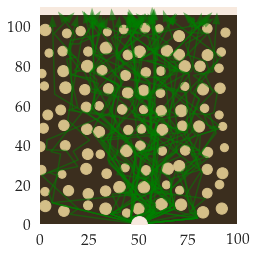

In [2186]:
plt.plot((0, 101), (111, 111), color="#F7E9DE", linewidth=20, linestyle="-",)
for i in range(100):
    circle = plt.Circle(tree_locs[i], tree_sizes[i], color='#D4BF88')
    plt.gca().add_patch(circle)
for traj in trajs:
    plt.plot(np.array(traj)[:, 0], np.array(traj)[:, 1], color="#008000", alpha=0.5)
    plt.arrow(np.array(traj)[:, 0][-1],
              np.array(traj)[:, 1][-1],
              (np.array(traj)[:, 0][-1] - np.array(traj)[:, 0][-2]),
             (np.array(traj)[:, 1][-1] - np.array(traj)[:, 1][-2]),
             shape='full', lw=0, length_includes_head=True, head_width=4 ,color="#008000", alpha=0.5, zorder=10)
    
plt.xlim(0, 100)
plt.ylim(0, 110)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor('#3B2E1E')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.scatter(50, 0, color="#F7E9DE", s=250, zorder=10)
plt.savefig("forest_demos" + ".pdf", dpi=1000, bbox_inches='tight')

We score the drone based on the final y position, with 100 being the maximum score. 

In [2063]:
def features(X):
    percep_feat = perception(X, nearest)
    if isinstance(X[0], torch.Tensor):
        f1 = torch.Tensor(percep_feat)
        feats = torch.cat([f1, X], axis=1)
    else:
        feats = np.concatenate([percep_feat, X], axis=1)
    return feats

In [2064]:
def eval_policy(pi):
    pos = [50, 0, np.pi/2 + (np.random.rand() - 0.5) * 0]
    while pos[1] < 100:
        theta = pi(features(np.array([pos])))
        theta = torch.clamp(theta, 0, np.pi)
        if perception(np.array([[pos[0], pos[1], theta]]), nearest):
            return pos[1]
        pos = dynamics(pos, theta)
        if pos[0] < 0 or pos[0] > 100:
            return 0
    return 100

In [2065]:
def rollout(pi, full=False, return_actions=False):
    pos = [50, 0, np.pi/2 + (np.random.rand() - 0.5) * 0]
    traj = [list(pos)]
    controls = []
    while pos[1] < 100:
        theta = pi(features(np.array([pos])))
        theta = torch.clamp(theta, 0, np.pi)
        controls.append(theta.numpy().sum().tolist())
        if perception(np.array([[pos[0], pos[1], theta]]), nearest):
            if full:
                traj.append(dynamics(pos, theta).tolist())
            if return_actions:
                return traj, controls
            return traj
        pos = dynamics(pos, theta)
        if pos[0] < 0 or pos[0] > 100:
            if return_actions:
                return traj, controls
            return traj
        traj.append(pos.tolist())
    if return_actions:
        return traj[:-1], controls
    return traj[:-1]

### Algorithm 1: DAgger

In [2066]:
def behavioral_cloning(X, U, net, loss_fn=nn.MSELoss()):
    optimizer = optim.Adam(net.parameters(), lr=3e-4)
    for step in range(int(5e3)):
        idx = np.random.choice(len(X), 32)
        states = torch.from_numpy(X[idx]).float()
        actions = torch.from_numpy(U[idx]).float()

        optimizer.zero_grad()

        outputs = net(states)
        loss = loss_fn(outputs, actions)
        loss.backward()
        optimizer.step()
    return lambda s: net(torch.from_numpy(np.array(s)).float()).detach()

In [2096]:
def dagger():
    J = []
    # Iteration 0: BC
    trajs = np.concatenate(collect_demos(10), axis=0)
    X = features(trajs)
    U = trajs[:, -1].reshape(-1, 1)
    net = create_network(i=4, o=1)
    policy = behavioral_cloning(X, U, net)
    J.append(np.mean([eval_policy(policy) for _ in range(10)]))
    # Iteration 1-N: Interactive corrections
    for i in range(9):
        trajs = np.concatenate([np.array(rollout(policy)) for _ in range(10)])
        X_new = features(trajs)
        U_new = np.array([expert(x) if expert(x) is not None else np.pi * np.random.uniform() for x in trajs]).reshape(-1, 1)
        X = np.concatenate([X, X_new], axis=0)
        U = np.concatenate([U, U_new], axis=0)
        policy = behavioral_cloning(X, U, net)
        J.append(np.mean([eval_policy(policy) for _ in range(10)]))
        print(J)
    return J, policy

In [2097]:
J_dagger = []
for _ in range(10):
    J, pi = dagger()
    print(J)
    J_dagger.append(J)

[0.0, 0.0]
[0.0, 0.0, 4.8383265]
[0.0, 0.0, 4.8383265, 0.0]
[0.0, 0.0, 4.8383265, 0.0, 65.71332]
[0.0, 0.0, 4.8383265, 0.0, 65.71332, 0.0]
[0.0, 0.0, 4.8383265, 0.0, 65.71332, 0.0, 4.951062]
[0.0, 0.0, 4.8383265, 0.0, 65.71332, 0.0, 4.951062, 16.000574]
[0.0, 0.0, 4.8383265, 0.0, 65.71332, 0.0, 4.951062, 16.000574, 7.117627]
[0.0, 0.0, 4.8383265, 0.0, 65.71332, 0.0, 4.951062, 16.000574, 7.117627, 31.258947]
[0.0, 0.0, 4.8383265, 0.0, 65.71332, 0.0, 4.951062, 16.000574, 7.117627, 31.258947]
[0.0, 4.948761]
[0.0, 4.948761, 4.929092]
[0.0, 4.948761, 4.929092, 0.0]
[0.0, 4.948761, 4.929092, 0.0, 4.895699]
[0.0, 4.948761, 4.929092, 0.0, 4.895699, 0.0]
[0.0, 4.948761, 4.929092, 0.0, 4.895699, 0.0, 0.0]
[0.0, 4.948761, 4.929092, 0.0, 4.895699, 0.0, 0.0, 4.8734803]
[0.0, 4.948761, 4.929092, 0.0, 4.895699, 0.0, 0.0, 4.8734803, 4.9678917]
[0.0, 4.948761, 4.929092, 0.0, 4.895699, 0.0, 0.0, 4.8734803, 4.9678917, 0.0]
[0.0, 4.948761, 4.929092, 0.0, 4.895699, 0.0, 0.0, 4.8734803, 4.9678917, 0.0]
[0.

In [2069]:
sample_traj = rollout(pi, full=True)

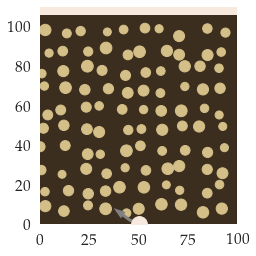

In [2191]:
plt.plot((0, 101), (111, 111), color="#F7E9DE", linewidth=20, linestyle="-",)
for i in range(100):
    circle = plt.Circle(tree_locs[i], tree_sizes[i], color='#D4BF88')
    plt.gca().add_patch(circle)
plt.plot(np.array(sample_traj)[:, 0], np.array(sample_traj)[:, 1], color="gray", linewidth=3)
plt.arrow(np.array(sample_traj)[:, 0][-1],
        np.array(sample_traj)[:, 1][-1],
        (np.array(sample_traj)[:, 0][-1] - np.array(sample_traj)[:, 0][-2]),
        (np.array(sample_traj)[:, 1][-1] - np.array(sample_traj)[:, 1][-2]),
        shape='full', lw=0, length_includes_head=True, head_width=4 , color="gray", alpha=1.0, zorder=10)
    
plt.xlim(0, 100)
plt.ylim(0, 110)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor('#3B2E1E')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.scatter(50, 0, color="#F7E9DE", s=250, zorder=10)
plt.savefig("forest_dagger" + ".pdf", dpi=1000, bbox_inches='tight')

## Algorithm 2: DAeQuIL

The operator uses her domain knowledge to include a sensible moment: the absolute value of the difference between the proposed and current headings.

In [2071]:
def moments(xb, ub):
    moment_1 = torch.from_numpy(perception(xb, nearest))
    moment_2 = xb
    moment_3 = torch.abs(ub - xb[:, -1:])
    return torch.cat([moment_1, moment_2, moment_3], dim=1)

In [2072]:
def f_best_resp(X, U_pi, U_expert):
    f = nn.Sequential(*create_mlp(5, 1, [32, 32], squash=False))
    optimizer = optim.Adam(f.parameters(), lr=3e-4)
    
    for step in range(int(1e3)):
        idx = np.random.choice(len(X), 32)
        states = torch.from_numpy(X[idx])
        a_pi = torch.from_numpy(U_pi[idx])
        a_E = torch.from_numpy(U_expert[idx])
        
        learner_moments = moments(states, a_pi)
        expert_moments = moments(states, a_E)
        

        f_learner = f(learner_moments.float())
        f_expert = f(expert_moments.float())
        gp = gradient_penalty(learner_moments, expert_moments, f, w=1.0) + gradient_penalty(learner_moments, expert_moments, f, w=0.0)
        
        optimizer.zero_grad()
        loss = f_expert.mean() - f_learner.mean() + 5 * gp 
        
        loss.backward()
        optimizer.step()
    return f

In [2073]:
def pi_no_regret(X, F, U, net, pi_opt, num_bc=100, first_iter=False):
    loss_fn = nn.MSELoss()
    for step in range(int(2e3)):
        bc_states = torch.from_numpy(X[:num_bc]).float()
        bc_actions = torch.from_numpy(U[:num_bc]).float()
        if not first_iter:
            idx = np.random.choice(len(X) - num_bc, 32)
            states = torch.from_numpy(X[idx + num_bc]).float()
            expert_actions = torch.from_numpy(U[idx + num_bc]).float()
            discs = [F[i] for i in idx + num_bc]

        bc_idx = np.random.choice(num_bc, 32)
        pi_opt.zero_grad()
        bc_preds = torch.clamp(net(features(bc_states[bc_idx]).float()), 0, np.pi)
        bc_loss = loss_fn(bc_preds, bc_actions[bc_idx].reshape(-1))
        mm_loss = 0.
                       
        if not first_iter:
            outputs = torch.clamp(net(features(states).float()), 0, np.pi)
            learner_sa = moments(states, outputs)
            mm_loss += torch.mean(torch.stack([discs[i](learner_sa[i:i+1].float()) for i in range(len(idx))]))
    
        loss = mm_loss * (1 - (num_bc / len(X))) + 5e-2 * bc_loss * (num_bc / len(X))
        loss.backward()
        pi_opt.step()
    return lambda s: net(torch.from_numpy(np.array(s)).float()).detach()

In [2195]:
def daequil():
    J = []
    # Iteration 0: BC
    trajs = np.concatenate(collect_demos(10), axis=0)
    X = trajs
    U = trajs[:, -1].reshape(-1, 1)
    F = [0 for _ in range(len(X))]
    net = create_network(i=4, o=1)
    pi_opt = optim.Adam(net.parameters(), lr=3e-4)
    policy = behavioral_cloning(features(X), U, net)
    J.append(np.mean([eval_policy(policy) for _ in range(10)]))
    print(J)
    num_bc = len(X)
    # Iteration 1-N: Interactive moment matching
    for i in range(9):
        res = [rollout(policy, return_actions=True) for _ in range(10)]
        trajs = np.concatenate([np.array(r[0]) for r in res], axis=0)
        ctrls = np.concatenate([np.array(r[1]) for r in res], axis=0)
        # Discriminator update
        X_new = trajs
        U_new = np.array([expert(x) if expert(x) is not None else np.pi * np.random.uniform() for x in trajs]).reshape(-1, 1)
        U_pi = ctrls.reshape(-1, 1)
        f_t = f_best_resp(X_new, U_pi, U_new)
        F.extend([f_t for _ in range(len(X_new))])
        # Policy update
        X = np.concatenate([X, X_new], axis=0)
        U = np.concatenate([U, U_new], axis=0)
        policy = pi_no_regret(X, F, U, net, pi_opt, num_bc=num_bc, first_iter=False)
        J.append(np.mean([eval_policy(policy) for _ in range(10)]))
        print(J)
        if J[-1] > 50:
            return J, policy
    return J, policy

In [2098]:
J_daequil = []
for _ in range(10):
    J, pi = daequil()
    print(J)
    J_daequil.append(J)

[0.0]
[0.0, 4.7517633]
[0.0, 4.7517633, 13.252083]
[0.0, 4.7517633, 13.252083, 1.2061713]
[0.0, 4.7517633, 13.252083, 1.2061713, 7.488028]
[0.0, 4.7517633, 13.252083, 1.2061713, 7.488028, 20.72973]
[0.0, 4.7517633, 13.252083, 1.2061713, 7.488028, 20.72973, 2.4990582]
[0.0, 4.7517633, 13.252083, 1.2061713, 7.488028, 20.72973, 2.4990582, 2.272236]
[0.0, 4.7517633, 13.252083, 1.2061713, 7.488028, 20.72973, 2.4990582, 2.272236, -4.3711393e-07]
[0.0, 4.7517633, 13.252083, 1.2061713, 7.488028, 20.72973, 2.4990582, 2.272236, -4.3711393e-07, 2.1146467]
[0.0, 4.7517633, 13.252083, 1.2061713, 7.488028, 20.72973, 2.4990582, 2.272236, -4.3711393e-07, 2.1146467]
[0.0]
[0.0, 33.92316]
[0.0, 33.92316, 2.205317]
[0.0, 33.92316, 2.205317, 2.9422424]
[0.0, 33.92316, 2.205317, 2.9422424, 62.392384]
[0.0, 33.92316, 2.205317, 2.9422424, 62.392384, 6.8228927]
[0.0, 33.92316, 2.205317, 2.9422424, 62.392384, 6.8228927, 2.216912]
[0.0, 33.92316, 2.205317, 2.9422424, 62.392384, 6.8228927, 2.216912, 3.849195]
[0

In [2099]:
J_daequil = np.array(J_daequil)
J_dagger = np.array(J_dagger)

In [2198]:
sample_traj = rollout(pi, full=True)

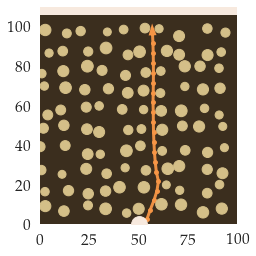

In [2212]:
plt.plot((0, 101), (111, 111), color="#F7E9DE", linewidth=20, linestyle="-",)
for i in range(100):
    circle = plt.Circle(tree_locs[i], tree_sizes[i], color='#D4BF88')
    plt.gca().add_patch(circle)
plt.plot(np.array(sample_traj)[:, 0], np.array(sample_traj)[:, 1], color="#F79646", linewidth=3, alpha=0.95)
plt.scatter(np.array(sample_traj)[:, 0], np.array(sample_traj)[:, 1], color="#F79646", s=15)
plt.arrow(np.array(sample_traj)[:, 0][-1],
        np.array(sample_traj)[:, 1][-1],
        (np.array(sample_traj)[:, 0][-1] - np.array(sample_traj)[:, 0][-2]),
        (np.array(sample_traj)[:, 1][-1] - np.array(sample_traj)[:, 1][-2]),
        shape='full', lw=0, length_includes_head=True, head_width=4 , color="#F79646", alpha=1.0, zorder=10)
    
plt.xlim(0, 100)
plt.ylim(0, 110)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor('#3B2E1E')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.scatter(50, 0, color="#F7E9DE", s=250, zorder=10)
plt.savefig("forest_daequil" + ".pdf", dpi=1000, bbox_inches='tight')

In [2102]:
def eval_expert(n):
    scores = []
    while len(scores) < n:
        traj = [[50, 0, np.pi/2]]
        pos = [50, 0, np.pi/2]
        failure = False
        while pos[1] < 100:
            theta = expert(pos)
            if theta is not None:
                pos = dynamics(pos, theta)
                if pos[0] < 0 or pos[0] > 100:
                    scores.append(pos[1])
                    break
            else:
                scores.append(pos[1])
                break
        if not failure:
            scores.append(pos[1])
    return scores

In [2103]:
fn_expert_perf = np.mean(eval_expert(50))

In [2104]:
print('J(pi_E)', fn_expert_perf)

J(pi_E) 65.32542796431018


In [2105]:
num_trials = 10

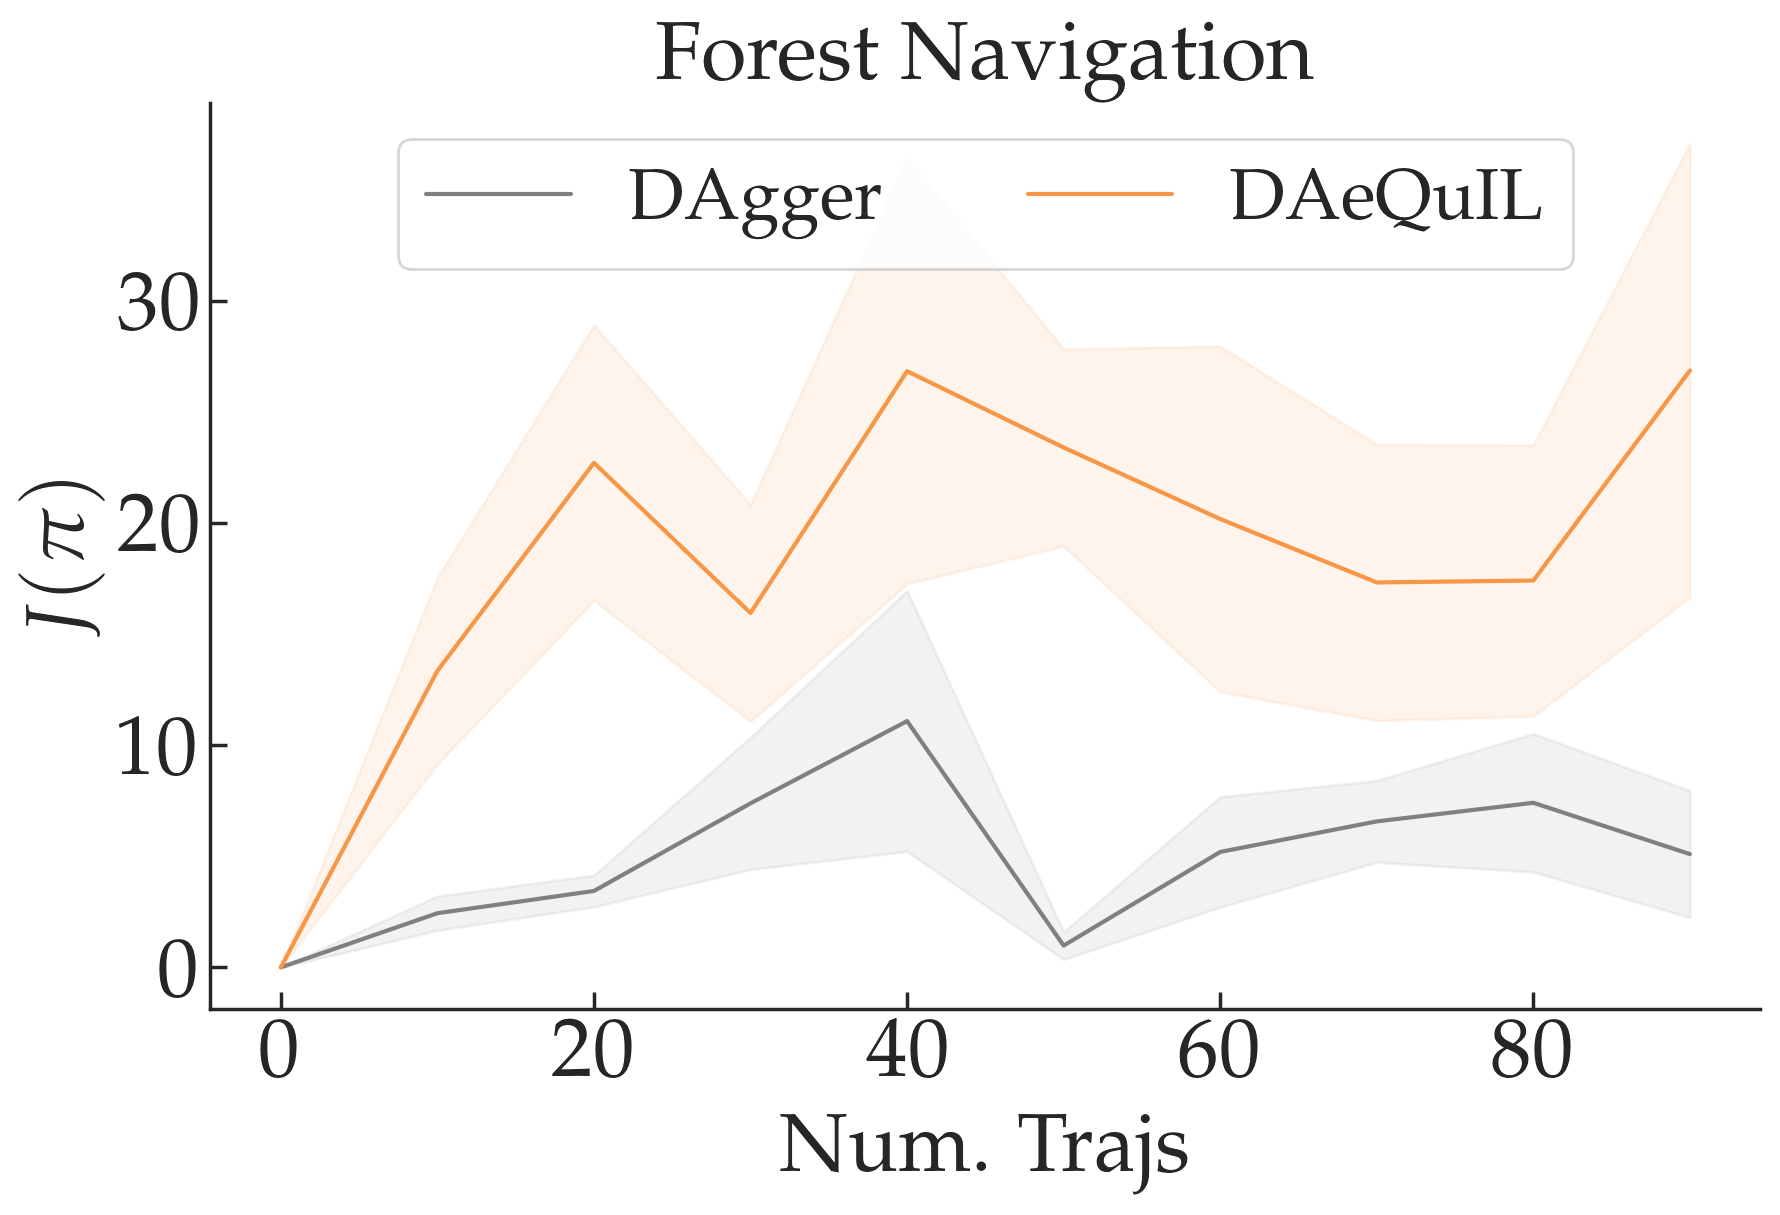

In [2219]:
setup_plot()
x_val = np.arange(10) * 10
plt.plot(x_val, J_dagger.mean(axis=0), label="DAgger", color="gray")
plt.fill_between(x_val,
                 J_dagger.mean(axis=0) - J_dagger.std(axis=0) / np.sqrt(num_trials),
                 J_dagger.mean(axis=0) + J_dagger.std(axis=0) / np.sqrt(num_trials),
                color="gray",
                alpha=0.1)
plt.plot(x_val, J_daequil.mean(axis=0), label="DAeQuIL", color="#F79646")
plt.fill_between(x_val,
                 J_daequil.mean(axis=0) - J_daequil.std(axis=0) / np.sqrt(num_trials),
                 J_daequil.mean(axis=0) + J_daequil.std(axis=0) / np.sqrt(num_trials),
                color="#F79646",
                alpha=0.1)
plt.xlabel("Num. Trajs", fontsize=30)
plt.ylabel("$J(\pi)$", fontsize=30)
plt.legend(ncol=2, prop={'size': 26}, loc="upper center")
plt.title("Forest Navigation", fontsize=30)
plt.savefig("forest_perfs" + ".pdf", dpi=1000, bbox_inches='tight')
plt.show()